In [1]:
import torch
from architecture import resnet50
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision

In [2]:
# load classes names
with open('sets/classes.txt', 'r') as f:
    classes = [l.strip() for l in f.readlines()]
print('Loaded {} classes:'.format(len(classes)))
print('\n'.join(classes))

Loaded 10 classes:
11H(ANTONY OF PADUA)
11H(JOHN THE BAPTIST)
11H(PAUL)
11H(FRANCIS)
11HH(MARY MAGDALENE)
11H(JEROME)
11H(DOMINIC)
11F(MARY)
11H(PETER)
11H(SEBASTIAN)


In [3]:
# initialize model
num_classes = 10
gradmodel = resnet50.Grad(num_classes) # Own Modification
cammodel = resnet50.CAM(num_classes)

In [4]:
# load weights
weights_path = 'model/res50.pth'
gradmodel.load_state_dict(torch.load(weights_path), strict=True)
cammodel.load_state_dict(torch.load(weights_path), strict=True)
print('Model loaded')

Model loaded


In [5]:
# set model to be run on GPU
gradmodel.cuda()
cammodel.cuda()
# set model to run on eval mode
gradmodel.eval()
cammodel.eval()

In [6]:
'''def normalize_img(img):
    
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    imgarr = np.asarray(img) / 255
    
    proc_img = np.empty_like(imgarr, np.float32)
    proc_img[..., 0] = (imgarr[..., 0] - mean[0]) / std[0]
    proc_img[..., 1] = (imgarr[..., 1] - mean[1]) / std[1]
    proc_img[..., 2] = (imgarr[..., 2] - mean[2]) / std[2]

    return proc_img

def HWC_to_CHW(img):
    return np.transpose(img, (2, 0, 1))

def prepro_img(img):
    img = normalize_img(img)
    img = HWC_to_CHW(img)
    img = np.expand_dims(img, axis=0)
    img = torch.from_numpy(img).cuda()
    return img'''

standard_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #transforms.Lambda(lambda x: torch.unsqueeze(x, 0))
])

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)


def get_cams(img, model):
    img_size = img.shape[2:]
    cams = model(img)
    high_res_cams = F.interpolate(cams, img_size, mode='bilinear', align_corners=False)
    high_res_cams = torch.squeeze(high_res_cams, 0)
    high_res_cams /= F.adaptive_max_pool2d(high_res_cams, (1, 1)) + 1e-5
    return high_res_cams

def get_score_indice(img, model):
    output = model(img)
    score, indice = torch.max(output, 1)
    return score, indice

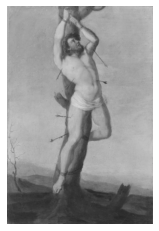

In [7]:
# load img
img_path = 'test-data/Q18599229.jpg'
image = np.asarray(imageio.imread(img_path))
#img_size = img.shape[:2]
# show img
plt.imshow(image)
plt.axis('off')
plt.show()

In [8]:
"""for c, p in list(zip(classes, probs)):
    print('{} - {:.4f}'.format(c, p))"""

"for c, p in list(zip(classes, probs)):\n    print('{} - {:.4f}'.format(c, p))"

In [9]:
#inverse transform to get normalize image back to original form for visualization


def saliency(img, gradmodel, cammodel, classes, visual=False):
    #input = prepro_img(img)
    if visual:
        img = standard_transform(img).cuda()
        #img = torch.unsqueeze(img, 0)
    img = torch.unsqueeze(img, 0)
    img.requires_grad = True
    
    score, indice = get_score_indice(img, gradmodel)
    if score < 1:
        img.detach()
        return None, None, None
    score.backward()
    slc = torch.sum(torch.abs(img.grad[0]), dim=0)
    img.detach()
    vmax = torch.quantile(slc, 0.99)
    vmin = torch.min(slc)
    slc = torch.clamp(slc, vmin, vmax)
    slc = (slc - slc.min())/(slc.max()-slc.min())
    
    class_name = classes[indice]
    
    high_res_cams = get_cams(img, cammodel)
    high_res_cam = high_res_cams[indice][0].detach()
    vmax = torch.quantile(high_res_cam, 0.99)
    vmin = torch.min(high_res_cam)
    high_res_cam = torch.clamp(high_res_cam, vmin, vmax)
    high_res_cam = (high_res_cam - high_res_cam.min())/(high_res_cam.max()-high_res_cam.min())

    
    
    if visual:
        with torch.no_grad():
            input_img = inv_normalize(img[0])
        #plot image and its saliency map
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
        plt.imshow(slc.cpu().numpy(), cmap=plt.cm.hot, alpha=0.5, vmin=0, vmax=1)
        plt.show()
        
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
        plt.imshow(high_res_cam.cpu().numpy(), cmap=plt.cm.hot, alpha=0.5, vmin=0, vmax=1)
        plt.show()
        
    return slc, high_res_cam, class_name

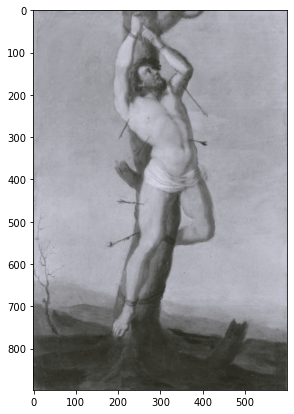

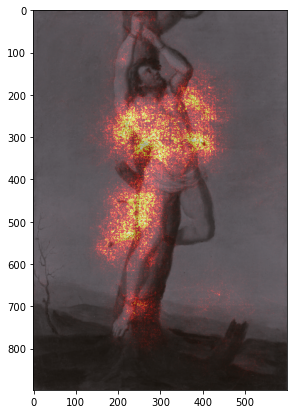

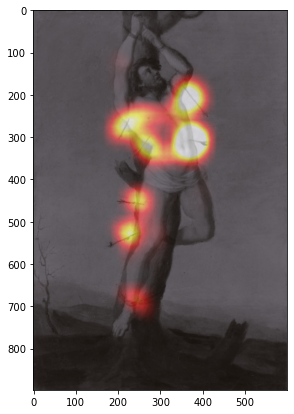

In [10]:
#from PIL import Image
#img = Image.open(img_path).convert('RGB')
slc, cam, class_name = saliency(image, gradmodel, cammodel, classes, visual=True)

In [11]:
def comparison(slc, cam):
    slc_total = torch.sum(slc)
    cam_total = torch.sum(cam)
    diff = torch.abs(slc_total - cam_total)
    avg_dis = diff / torch.numel(slc)
    slc_importance = slc >= 0.5
    cam_importance = cam >= 0.5
    avg_importance_count = torch.round(torch.sum(slc_importance == True) + torch.sum(cam_importance == True) / 2) 
    agreement = torch.sum((slc_importance == cam_importance) * (slc_importance == True))
    agreement_percentage = agreement / avg_importance_count
    
    return avg_dis, agreement_percentage

    
comparison(slc, cam)

(tensor(0.0110, device='cuda:0'), tensor(0.3167, device='cuda:0'))

In [12]:
# sort these by predicted class?
# how fast does this run test? Should save results in steps?
# How to deal with images wihout saints?

dataset = torchvision.datasets.ImageFolder(root='DEVKitArtDL/DEVKitArt', transform = standard_transform)
standardloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

print(len(standardloader))

avg_distances, agreement_percentages = [], []

def com_analysis(standardloader, gradmodel, cammodel, classes):
    avg_distances, agreement_percentages = [], []
    for i, data in enumerate(standardloader, 0):
        if i % 500 == 0:
            print(i / len(standardloader))
        for j in data[0]:
            slc, cam, class_name= saliency(j.cuda(), gradmodel, cammodel, classes)
            if class_name == None:
                continue
            avg_dis, agreement_percentage = comparison(slc, cam)
            avg_distances.append(avg_dis.item())
            agreement_percentages.append(agreement_percentage.item())
    return avg_distances, agreement_percentages

avg_distances, agreement_percentages = com_analysis(standardloader, gradmodel, cammodel, classes)
print("Average Distance per pixel:")       
print(sum(avg_distances / len(avg_distances)))
print("Average importance agreement per image:")
print(sum(agreement_percentages / len(agreement_percentages)))

42479
0.0
0.011770521904941265
0.02354104380988253
0.035311565714823794
0.04708208761976506
0.05885260952470633
0.07062313142964759
0.08239365333458885
0.09416417523953012
0.10593469714447139
0.11770521904941265
0.1294757409543539
0.14124626285929517
0.15301678476423644
0.1647873066691777
0.17655782857411897
0.18832835047906024
0.2000988723840015
0.21186939428894278
0.22363991619388404
0.2354104380988253
0.24718096000376658
0.2589514819087078
0.2707220038136491
0.28249252571859035
0.2942630476235316
0.3060335695284729
0.31780409143341415
0.3295746133383554
0.3413451352432967
0.35311565714823795
0.3648861790531792
0.3766567009581205
0.38842722286306175
0.400197744768003
0.4119682666729443
0.42373878857788555
0.4355093104828268
0.4472798323877681
0.45905035429270935
0.4708208761976506
0.4825913981025919
0.49436192000753315
0.5061324419124744
0.5179029638174156
0.529673485722357
0.5414440076272982
0.5532145295322395
0.5649850514371807
0.576755573342122
0.5885260952470632
0.600296617152004

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [17]:
np_avg_distances = np.array(avg_distances)
np_agreement_percentages = np.array(agreement_percentages)

np.savetxt("saliency/np_avg_distances.csv", np_avg_distances, delimiter=",")
np.savetxt("saliency/np_agreement_percentages.csv", np_agreement_percentages, delimiter=",")

In [19]:
print("Average Distance per pixel:")       
print(sum(np_avg_distances) / len(avg_distances))
print("Average importance agreement per image:")
print(sum(np_agreement_percentages) / len(agreement_percentages))

Average Distance per pixel:
0.04192818501753546
Average importance agreement per image:
0.2363789214999065
